# Pytorch.geometric

In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils import to_networkx
from utils.data import *
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from utils.plot import plot_map
import networkx as nx

## Easy example

In [1]:
from typing import Any

# create a graph from scratch
import torch
from pytorch_lightning.utilities.types import STEP_OUTPUT
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2, 0],
                           [1, 0, 2, 1, 2]], dtype=torch.long) # shape (2, num_edges)
x = torch.tensor([[-1, 2, 3],
                  [0, 2, 3],
                  [1, 2, 3],
                  [1, 2, 4]], dtype=torch.float) # node features
mask = torch.tensor([1, 0, 0, 1])

data = Data(x=x, edge_index=edge_index, train_mask=mask)
data

# scatter function
from torch_geometric.utils import scatter
s = scatter(data.x, data.train_mask, dim=0, reduce='mean')
s

tensor([[0.5000, 2.0000, 3.0000],
        [0.0000, 2.0000, 3.5000]])

In [2]:
# edge_index = torch.tensor([[0, 1, 1, 2, 0, 3],
#                            [1, 0, 2, 1, 2, 0]], dtype=torch.long)
# would throw an error here
data.validate(raise_on_error=True)

True

In [3]:
print(data.keys)
print(data['edge_index'].shape)
for key, item in data:
    print(f"{key} found in Data")
print('edge_attr' in data)
device = torch.device('cuda') # this is automatically done by Lightning apparently
data = data.to(device) # automatically done by Lightning

<bound method BaseData.keys of Data(x=[4, 3], edge_index=[2, 5], train_mask=[4])>
torch.Size([2, 5])
x found in Data
edge_index found in Data
train_mask found in Data
False


## Pytorch (Tutorial 12)

- extract node ids belonging to a graph in the dataset and using this extract attributes
- extract graph labels and graph connectivity (edges)
- graph information => convert to numpy arrays first and then to tensors torch.tensor(attr.to_numpy(), dtype=torch.float)
-

### Data object

In [5]:
node_features = torch.rand((100, 10), dtype=torch.float)
rows = np.random.choice(100, 500)
cols = np.random.choice(100, 500)
edges = torch.tensor([rows, cols])

edges_attr = np.random.choice(3, 500) #(0, 1, 2) => how can I have more then 1 edge attribute?
ys = torch.rand([100]).round().long()

/tmp/ipykernel_1988913/3767815847.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  edges = torch.tensor([rows, cols])


In [6]:
graph = data.Data(x = node_features, edge_index = edges, edge_attr=edges_attr, y = ys)
graph

Data(x=[100, 10], edge_index=[2, 500], edge_attr=[500], y=[100])

In [7]:
for prop in graph:
    print(prop)

('x', tensor([[1.7690e-01, 8.5244e-01, 4.6272e-01, 4.7008e-01, 2.5433e-01, 8.5330e-01,
         5.5082e-01, 8.1108e-01, 6.7994e-02, 2.0426e-01],
        [6.4273e-01, 6.5457e-01, 3.9785e-01, 3.1800e-01, 2.2349e-01, 1.5291e-01,
         1.9946e-01, 7.3977e-01, 6.1830e-01, 6.6294e-01],
        [7.8573e-01, 9.4630e-01, 7.5264e-01, 1.1248e-01, 3.1613e-02, 5.5595e-01,
         7.9765e-01, 3.4845e-01, 5.7366e-01, 5.7454e-01],
        [7.6131e-01, 3.2052e-01, 4.3410e-01, 3.2562e-01, 4.8838e-01, 9.6165e-01,
         8.6771e-01, 1.1933e-01, 3.0329e-01, 2.3218e-01],
        [8.2849e-01, 3.8492e-01, 7.3914e-01, 3.8060e-01, 1.6015e-01, 2.5382e-01,
         6.3903e-01, 8.2737e-01, 7.3811e-02, 6.9971e-01],
        [5.1351e-01, 5.1164e-01, 4.3273e-01, 8.5331e-01, 3.9068e-01, 4.2837e-01,
         1.8960e-01, 7.3890e-01, 9.9525e-02, 9.0950e-01],
        [3.3482e-02, 5.0714e-01, 5.8944e-01, 8.0548e-01, 7.4253e-01, 2.6245e-01,
         7.1111e-01, 8.8876e-01, 9.1344e-01, 1.0063e-01],
        [4.6153e-01, 

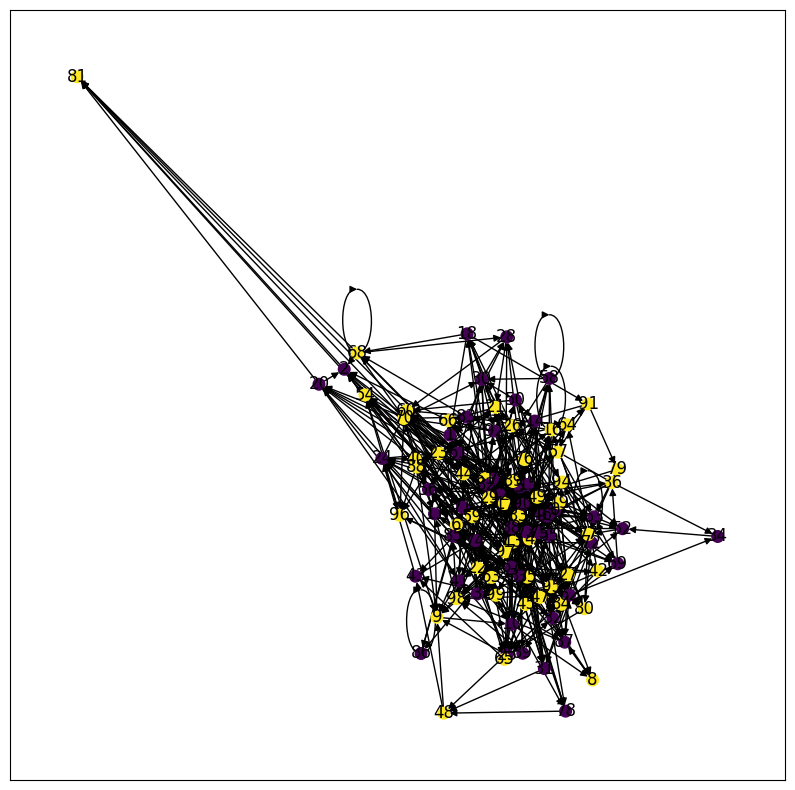

In [8]:
vis = to_networkx(graph)
node_labels = graph.y.numpy()
plt.figure(1, figsize=(10, 10))
nx.draw_networkx(vis, node_size = 70, node_color = node_labels)
plt.show()

In [9]:
graph2 = graph

In [10]:
batch = data.Batch().from_data_list([graph, graph2])

In [25]:
print(f"number of graphs: {batch.num_graphs}")
print(f"graph at index 1: {batch}")
print(f"Retrieve the list of graphs: {batch.to_data_list()}")

number of graphs: 2
graph at index 1: DataDataBatch(x=[200, 10], edge_index=[2, 1000], edge_attr=[2], y=[200], batch=[200], ptr=[3])
Retrieve the list of graphs: [Data(x=[100, 10], edge_index=[2, 500], edge_attr=[500], y=[100]), Data(x=[100, 10], edge_index=[2, 500], edge_attr=[500], y=[100])]


### Dataset object

In [15]:
import os
import pandas as pd


In [16]:
raw_dir = "tmp/raw/"

path = os.path.join(raw_dir, 'FRANKENSTEIN.node_attrs')
node_attrs = pd.read_csv(path, sep=',', header=None)
node_attrs.index += 1

path = os.path.join(raw_dir, 'FRANKENSTEIN.edges')
edge_index = pd.read_csv(path, sep=',', names=['source', 'target'])
edge_index.index += 1

path = os.path.join(raw_dir, 'FRANKENSTEIN.graph_idx')
graph_idx = pd.read_csv(path, sep=',', names=['idx'])
graph_idx.index += 1

path = os.path.join(raw_dir, 'FRANKENSTEIN.graph_labels')
graph_labels = pd.read_csv(path, sep=',', names=['label'])
graph_labels.index += 1

FileNotFoundError: [Errno 2] No such file or directory: 'tmp/raw/FRANKENSTEIN.node_attrs'

## Use EUPPBench Data
Moritz:
- normalize features and create graphs
- create graphs using create_multigraph

In [2]:
dfs = load_dataframes(mode="train", leadtime="24h")
stations = dfs["stations"]
df_target = dfs['train'][1]
df = dfs['train'][0]

[INFO] Dataframes exist. Will load pandas dataframes.


In [3]:
df_target
df_target[df_target.time == "1997-01-02"].head()

,time,station_id,t2m
0,1997-01-02,0,277.75
1,1997-01-02,1,279.55
2,1997-01-02,2,276.45
3,1997-01-02,3,275.75
4,1997-01-02,4,279.35


In [99]:
df.head()

,number,station_id,time,cape,model_orography,sd,station_altitude,station_latitude,station_longitude,stl1,...,ssr6,ssrd6,str6,strd6,tp6,z,q,u,v,t
0,0,0,1997-01-02,0.515625,-1.706008,0.0,1.2,52.928,4.781,281.966064,...,0.0,0.0,-1183741.0,6533068.0,0.000038,53168.78125,0.001777,-8.083289,15.863815,271.745361
1,0,1,1997-01-02,3.046875,-1.298122,0.0,-3.3,52.318,4.790,279.299561,...,0.0,0.0,-933629.0,6394828.0,0.000541,53179.28125,0.003039,1.166711,10.319870,271.828369
2,0,2,1997-01-02,0.000000,0.333424,0.0,10.8,53.241,4.921,281.732178,...,0.0,0.0,-826109.0,6875596.0,0.000040,53198.28125,0.001025,-7.635047,14.503464,272.024658
3,0,3,1997-01-02,0.015625,1.302155,0.0,0.7,53.392,5.346,281.952881,...,0.0,0.0,-833533.0,6891980.0,0.000154,53237.65625,0.000767,-7.935828,12.798386,272.303955
4,0,4,1997-01-02,3.703125,2.576800,0.0,1.9,52.100,5.180,278.962158,...,0.0,0.0,-1030141.0,6236876.0,0.000784,53226.65625,0.002784,0.735070,11.590378,271.850342


#### One ensemble member

In [ ]:
# add normalization

In [4]:
# create nodes of graph
stations = df['station_id'].unique()

In [5]:
# add edges
max_dist = 100
dist = load_distances(dfs["stations"])
mask = get_mask(dist, max_dist=max_dist) # mask = adjmatrix
print(mask.shape)
edges = np.argwhere(mask)
edge_index = torch.tensor(edges.T)
print(edge_index.shape) # creating real distmatrix necessary? those that are not connected = infinity? => macht keinen Sinn
print(np.sum(mask))

[INFO] Computing distances...
(122, 122)
torch.Size([2, 1420])
1420


In [6]:
# add edge features
# edge attribute = proximity (shape: (2, num_edges), num_edges = 1420
print(dist[mask])
edge_attr = dist[mask]
print(np.array_equal(dist[edges[:, 0], edges[:, 1]], dist[mask]))
edge_attr = torch.tensor(edge_attr.reshape(-1,1))
print(edge_attr)
print(edge_attr.shape) # shape: (num_edges, 1)

# standardization from Moritz:
#max_len = np.max(edge_attr)
#print(max_len)
#standardized_edge_attr = edge_attr / max_len

[67.88302104 36.07414311 63.98981385 ... 67.77742374 55.46816552
 31.99306735]
True
tensor([[67.8830],
        [36.0741],
        [63.9898],
        ...,
        [67.7774],
        [55.4682],
        [31.9931]], dtype=torch.float64)
torch.Size([1420, 1])


### Create a graph
Pytorch data object
- .x (num_nodes, num_node_feats)
- .edge_index (2, num_edges)
- .edge_attr (num_edges, num_edge_feats)
- .y (num_nodes, *)
- .pos (num_nodes, node_dim)

In [7]:
# create data object for one ensemble member (should all be the same)
date = '1997-01-02'
day = df[df.time == date]
ensemble = 0
first_ens = day[day.number == ensemble]
first_ens = first_ens.drop(columns=["time", "number"])
#print(first_ens)
x = torch.tensor(first_ens.to_numpy(dtype=np.float32))
target = df_target[df_target.time == date]
target = target.drop(columns=["time", "station_id"]).to_numpy()
y = torch.tensor(target)
print(type(target))
lon = first_ens["station_longitude"].to_numpy().reshape(-1, 1)
print(lon.shape)
lat = first_ens["station_latitude"].to_numpy().reshape(-1, 1)
print(lat.shape)
pos = torch.tensor(np.concatenate([lon, lat], axis=1))

# Moritz has a conversion to celsius here, but should do it elsewhere (preprocess?)

# check sizes:
print(f"{df.station_id.nunique()} nodes and {np.sum(mask)} edges")
print(f"x: {x.shape}")
print(f"edge_index: {edge_index.shape}")
print(f"edge_attr: {edge_attr.shape}")
print(f"y: {y.shape}")
print(f"pos: {pos.shape}")

<class 'numpy.ndarray'>
(122, 1)
(122, 1)
122 nodes and 1420 edges
x: torch.Size([122, 34])
edge_index: torch.Size([2, 1420])
edge_attr: torch.Size([1420, 1])
y: torch.Size([122, 1])
pos: torch.Size([122, 2])


In [8]:
graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, timestap=date, y=y, pos=pos)
graph
pos.numpy().reshape(-1, 2)

array([[ 4.781     , 52.928     ],
       [ 4.79      , 52.318     ],
       [ 4.921     , 53.241     ],
       [ 5.346     , 53.392     ],
       [ 5.18      , 52.1       ],
       [ 5.384     , 52.898     ],
       [ 5.52      , 52.458     ],
       [ 5.752     , 53.224     ],
       [ 5.888     , 52.703     ],
       [ 5.873     , 52.056     ],
       [ 6.2       , 53.413     ],
       [ 6.259     , 52.435     ],
       [ 6.574     , 52.75      ],
       [ 6.585     , 53.125     ],
       [ 6.657     , 52.069     ],
       [ 7.15      , 53.196     ],
       [ 6.891     , 52.274     ],
       [ 3.596     , 51.442     ],
       [ 3.861     , 51.226     ],
       [ 3.884     , 51.527     ],
       [ 4.122     , 51.992     ],
       [ 4.342     , 51.449     ],
       [ 4.447     , 51.962     ],
       [ 4.926     , 51.97      ],
       [ 4.936     , 51.566     ],
       [ 5.146     , 51.859     ],
       [ 5.377     , 51.451     ],
       [ 5.707     , 51.659     ],
       [ 5.762     ,

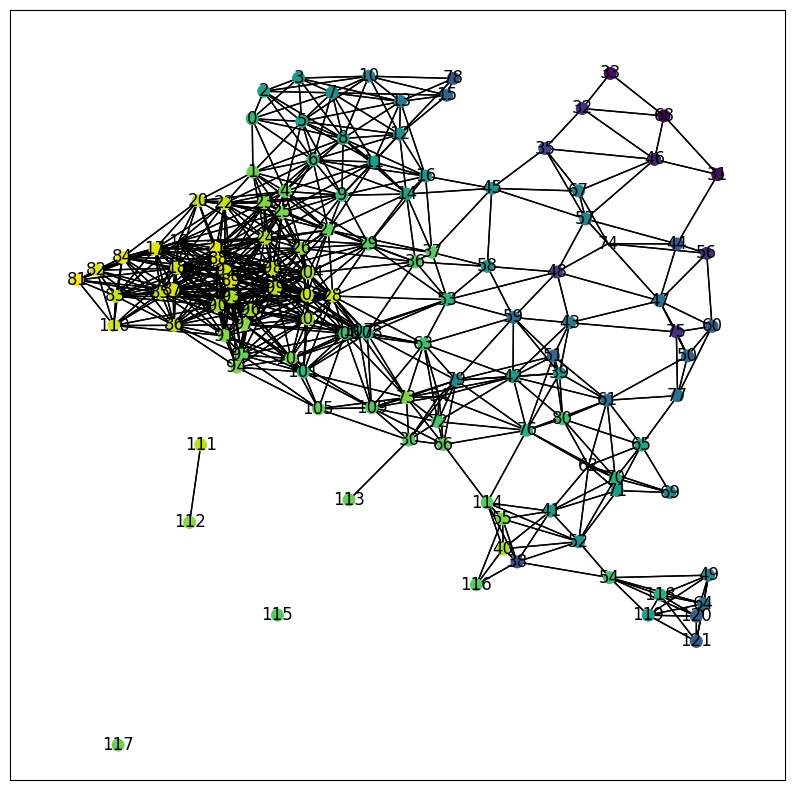

In [15]:
# visualisation
pos_dict = dict(enumerate(graph.pos.numpy().reshape(-1, 2)))
vis = to_networkx(graph)
plt.figure(1, figsize=(10, 10))
nx.draw_networkx(vis, node_size = 70, node_color = graph.y.numpy(), pos=pos_dict, arrows=False)
plt.show()

##### With map:

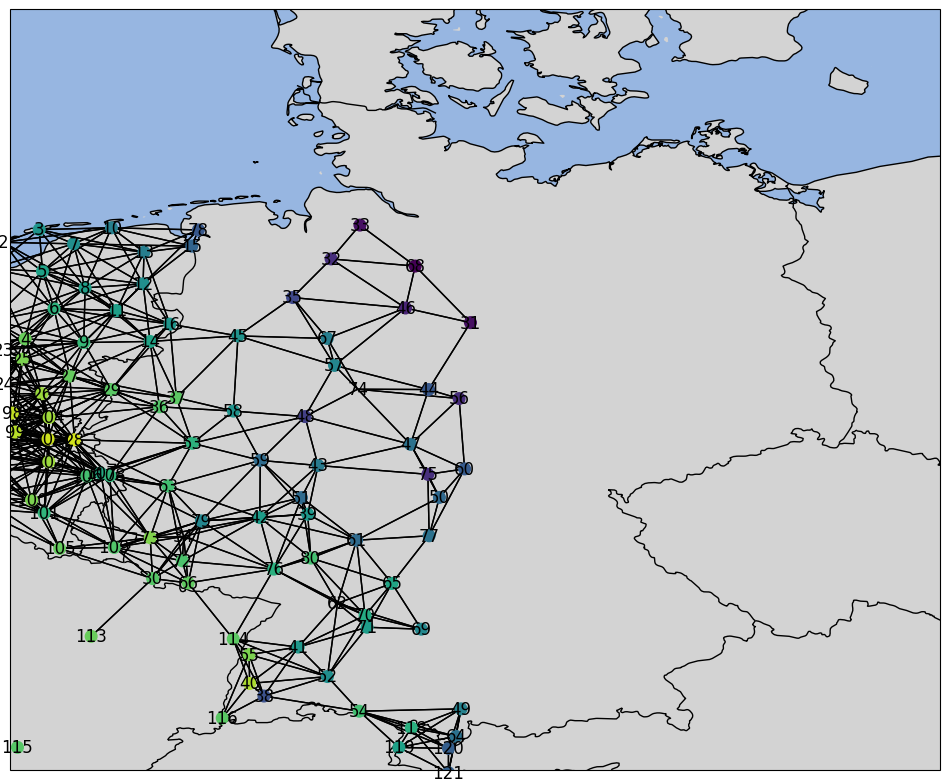

In [16]:
# Plot map (ax = plot_map())
ax = plot_map() # set_extent and fix aspect ratio in this function!
# ax.set_title("Active weather stations in Germany")

# Plot Graph
nx.draw_networkx(vis, node_size = 70, node_color = graph.y.numpy(), pos=pos_dict, arrows=False, ax=ax)
plt.show()

#### Adding edges

In [ ]:
# add edges for altitude => how is distance calculated? => calculate altitude differences!

# alt_dist

# should I add edges between those that are close to each other by altitude
# additional edge attribute = altitude

#### All ensemble members

In [ ]:
# for-loop for all ensemble members => nur Unterschiede in features: x


#### Dataset creation

In [ ]:
# for-loop for all times appended in Dataset or in list?
all_graphs = []
for date in df.time.unique():
    day = df[df.time == date]
    ensemble = 0
    first_ens = day[day.number == ensemble]
    first_ens = first_ens.drop(columns=["time", "number"])
    #print(first_ens)
    x = torch.tensor(first_ens.to_numpy(dtype=np.float32))
    target = df_target[df_target.time == date]
    target = target.drop(columns=["time", "station_id"]).to_numpy()
    y = torch.tensor(target)
    print(type(target))
    lon = first_ens["station_longitude"].to_numpy().reshape(-1, 1)
    print(lon.shape)
    lat = first_ens["station_latitude"].to_numpy().reshape(-1, 1)
    print(lat.shape)
    pos = torch.tensor(np.concatenate([lon, lat], axis=1))

    graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, timestap=date, y=y, pos=pos)
    all_graphs.append(graph)

## Create_multigraph data

In [19]:
df = load_dataframes(mode="train", leadtime="24h")
stations = df["stations"]
print(stations.columns)

[INFO] Dataframes exist. Will load pandas dataframes.
Index(['station_id', 'lat', 'lon', 'altitude', 'name'], dtype='object')


In [20]:
# d besteht aus edge_index,
dist = load_distances(df["stations"])
max_dist = 100

#graphs_train_rf, tests = normalize_features_and_create_graphs(
#    training_data=df["train"],
#    valid_test_data=[df["test_rf"], df["test_f"]],
#    mat=dist,
#    max_dist=max_dist,
#)
graph = create_multigraph(df["train"][0], df["train"][1], distances=dist, max_dist=max_dist)


[INFO] Computing distances...


In [23]:
print(type(graph)) # wieso list, wieso nicht als Dataset?
for g in graph:
    print(g)
g_idx =  24
node_ids = graph.loc[graph['station']==g_idx].index
node_ids

<class 'list'>
Data(x=[1342, 34], edge_index=[2, 29040], edge_attr=[29040, 1], y=[122], timestamp=1997-01-02 00:00:00, n_idx=[1342])
Data(x=[1342, 34], edge_index=[2, 29040], edge_attr=[29040, 1], y=[122], timestamp=1997-01-05 00:00:00, n_idx=[1342])
Data(x=[1342, 34], edge_index=[2, 29040], edge_attr=[29040, 1], y=[122], timestamp=1997-01-09 00:00:00, n_idx=[1342])
Data(x=[1342, 34], edge_index=[2, 29040], edge_attr=[29040, 1], y=[122], timestamp=1997-01-12 00:00:00, n_idx=[1342])
Data(x=[1342, 34], edge_index=[2, 29040], edge_attr=[29040, 1], y=[122], timestamp=1997-01-16 00:00:00, n_idx=[1342])
Data(x=[1342, 34], edge_index=[2, 29040], edge_attr=[29040, 1], y=[122], timestamp=1997-01-19 00:00:00, n_idx=[1342])
Data(x=[1342, 34], edge_index=[2, 29040], edge_attr=[29040, 1], y=[122], timestamp=1997-01-23 00:00:00, n_idx=[1342])
Data(x=[1342, 34], edge_index=[2, 29040], edge_attr=[29040, 1], y=[122], timestamp=1997-01-26 00:00:00, n_idx=[1342])
Data(x=[1342, 34], edge_index=[2, 29040],

AttributeError: 'list' object has no attribute 'loc'

# Using NetworkX for Graph Visualisation

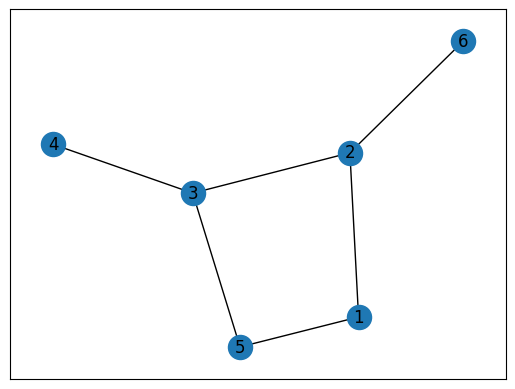

In [79]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
edge_list = [(1, 2), (3, 4), (2, 3), (1, 5), (3, 5), (2, 6)]
G.add_edges_from(edge_list)
nx.draw_networkx(G, with_labels=True)

{0: 2, 1: 5, 2: 2, 3: 3}
2


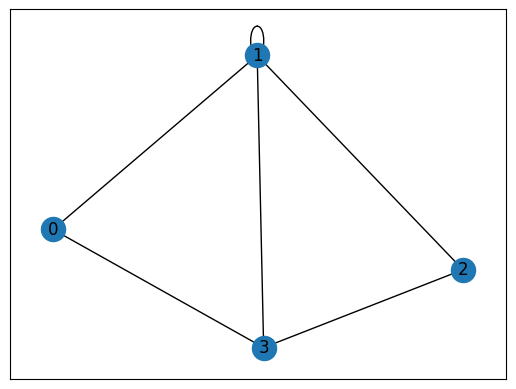

In [111]:
import numpy as np
adjm = np.array([[0, 1, 0, 1],
                [1, 1, 1, 1],
                [0, 1, 0, 1],
                [1, 1, 1, 0]])

distm = np.array([[50, 31, 27, 12],
                [31, 36, 5, 73],
                [27, 5, 33, 19],
                [12, 73, 19, 0]])

G = nx.from_numpy_array(adjm, distm)
nx.draw_networkx(G)
print(dict(G.degree))
print(nx.shortest_path_length(G, 0, 2))
# how do I add distances? edge_features? node_features? => use pytorch.geomtric for this!

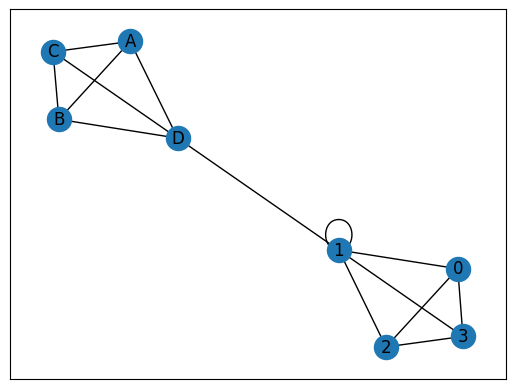

In [113]:
G1 = nx.complete_graph(4)
G1.add_edge(1, 1)
G2 = nx.complete_graph(4)
letter_map = {i: chr(65 + i) for i in range(0, 4)}
G2 = nx.relabel_nodes(G2, letter_map)
G_connect = nx.from_edgelist([(1, "D")])
G_total = nx.compose_all([G1, G2, G_connect])
nx.draw_networkx(G_total)


In [112]:
print(nx.degree_centrality(G_total))
print(nx.betweenness_centrality(G_total))
print(nx.density(G_total))
print(nx.diameter(G_total)) # longest shortest path
print(list(nx.bridges(G_total)))
# how do I remove edges?
G_total.remove_edge(1, "D")
G_total.remove_self
print(list(nx.connected_components(G_total)))

{0: 0.42857142857142855, 1: 0.5714285714285714, 2: 0.42857142857142855, 3: 0.42857142857142855, 'A': 0.42857142857142855, 'B': 0.42857142857142855, 'C': 0.42857142857142855, 'D': 0.5714285714285714}
{0: 0.0, 1: 0.5714285714285714, 2: 0.0, 3: 0.0, 'A': 0.0, 'B': 0.0, 'C': 0.0, 'D': 0.5714285714285714}
0.4642857142857143
3
[(1, 'D')]
[{0, 1, 2, 3}, {'C', 'A', 'D', 'B'}]


# GNNs

## GNN with Planetoid - learn how to translate into Lightning!

In [57]:
from torch_geometric.datasets import Planetoid
from torch.utils.data import DataLoader

dataset = Planetoid(root="tutorial1",name= "Cora")
train_loader = DataLoader(dataset, batch_size=15, shuffle=True)

Processing...
Done!


In [72]:
print(len(dataset))
print(dataset.data.num_nodes)
print(dataset.num_node_features)
print(dataset.data)
print(dataset.data.y)
data = dataset[0]

1
2708
1433
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
tensor([3, 4, 4,  ..., 3, 3, 3])


In [54]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import pytorch_lightning as L

class GCN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)


In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [56]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8050
